In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from pymc3 import model_to_graphviz
plt.style.use("fivethirtyeight")

C:\Users\tanve\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\tanve\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


We will implement the eight schools problem from Section 5.5 in Gelman et al. 2013 and compare traditional methods vs. the new method proposed in the Vehtari et al. 2019 paper.

In this problem, the Educational Testing Services company studied the effects of coaching on SAT scores.

In [2]:
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

In [3]:
with pm.Model() as hierarchical:

    mu = pm.Normal('mu', 0, 5)
    tau = pm.Cauchy('tau', 0, 5)

    theta = pm.Normal('theta', mu, tau)
    obs = pm.Normal('obs', theta, sigma=sigma, observed=y)

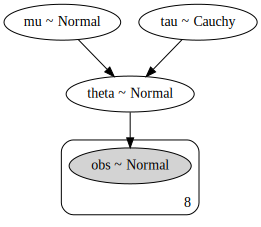

In [4]:
model_to_graphviz(hierarchical)

In [ ]:
with hierarchical:
    trace = pm.sample(1000, tune=1000, step = pm.SMC())